## Load module

In [0]:
% matplotlib inline
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

from keras.models import Model
from keras import layers as klayers
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [0]:
# Make sure keras running on GPU
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

## Load train image and label from Google drive

The demo dataset is ISBI Challenge: Segmentation of neuronal structures in EM stacks. Its website: http://brainiac2.mit.edu/isbi_challenge/home. All figure were converted to PNG files.

### Set data path

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
myDrive = '/content/gdrive/My Drive/'

# TODO: modify the following two paths
train_path = os.path.join(myDrive, 'ISBI', 'train')
test_path = os.path.join(myDrive, 'ISBI', 'test')

### Read train images and labels

In [0]:
# load train images
input_shape = (512, 512, 1)
train_image = np.empty(30 * 512 * 512)
train_image = train_image.reshape((30, ) + input_shape)
for i in range(30):
    img_path = os.path.join(train_path, 'image/' + str(i) + '.png')
    img = Image.open(img_path)
    img = np.array(img, dtype = np.float32)
    img /= 255
    train_image[i, :, :, 0] = img

    
# load train labels
train_label = np.empty(30 * 512 * 512)
train_label = train_label.reshape((30, ) + input_shape)
for i in range(30):
    img_path = os.path.join(train_path, 'label/' + str(i) + '.png')
    img = Image.open(img_path)
    img = np.array(img, dtype = np.float32)
    img /= 255
    train_label[i, :, :, 0] = img

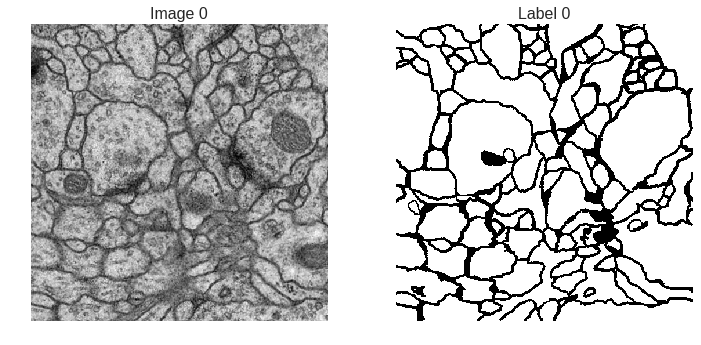

In [0]:
fig = plt.figure(figsize = (12, 12))

plt.subplot(221)
plt.imshow(train_image[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.title('Image 0', fontsize=16)

plt.subplot(222)
plt.imshow(train_label[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.title('Label 0', fontsize=16)

plt.show()

## Build a U-Net model

### Loss function

In [0]:
def dice_coefficient(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

### U-Net Network

In [0]:
def unet(pretrained_weights=None, input_size=[512, 512, 1], depth=3, init_filter=8, 
         filter_size=3, padding='same', pool_size=[2, 2], strides=[2, 2]):
    
    inputs = klayers.Input(input_size)
    
    current_layer = inputs
    encoding_layers = []
    
    # Encoder path
    for d in range(depth + 1):
        num_filters = init_filter * 2 ** d
        
        conv = klayers.Conv2D(num_filters, filter_size, padding=padding,
                              kernel_initializer='he_normal')(current_layer)
        conv = klayers.BatchNormalization()(conv)
        conv = klayers.Activation('relu')(conv)
        conv = klayers.Conv2D(num_filters, filter_size, padding=padding,
                              kernel_initializer='he_normal')(conv)
        conv = klayers.BatchNormalization()(conv)
        conv = klayers.Activation('relu')(conv)
        
        encoding_layers.append(conv)
        
        pool = klayers.MaxPooling2D(pool_size=pool_size)(conv)
        
        if d == depth:
            # Bridge
            current_layer = conv
        else:
            current_layer = pool
    
    # Decoder path
    for d in range(depth, 0, -1):
        num_filters = init_filter * 2 ** d
        up = klayers.Deconvolution2D(num_filters * 2, pool_size,
                                     strides=strides)(current_layer)
        
        crop_layer = encoding_layers[d - 1]
        # Calculate two layers shape
        up_shape = np.array(up._keras_shape[1:-1])
        conv_shape = np.array(crop_layer._keras_shape[1:-1])

        # Calculate crop size of left and right
        crop_left = (conv_shape - up_shape) // 2

        crop_right = (conv_shape - up_shape) // 2 + (conv_shape - up_shape) % 2
        crop_sizes = tuple(zip(crop_left, crop_right))

        crop = klayers.Cropping2D(cropping=crop_sizes)(crop_layer)

        # Concatenate
        up = klayers.Concatenate(axis=-1)([crop, up])
        conv = klayers.Conv2D(num_filters, filter_size, padding=padding,
                              kernel_initializer='he_normal')(up)
        conv = klayers.BatchNormalization()(conv)
        conv = klayers.Activation('relu')(conv)
        conv = klayers.Conv2D(num_filters, filter_size, padding=padding,
                              kernel_initializer='he_normal')(conv)
        conv = klayers.BatchNormalization()(conv)
        conv = klayers.Activation('relu')(conv)
        
        current_layer = conv
    
    
    outputs = klayers.Conv2D(1, 1, padding=padding,
                             kernel_initializer='he_normal')(current_layer)
    outputs = klayers.Activation('sigmoid')(outputs)
    model = Model(inputs=inputs, outputs=outputs)

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [0]:
model = unet(depth=3)
model.compile(optimizer=Adam(lr=1e-4), loss=dice_coefficient_loss, metrics=[dice_coefficient, 'accuracy'])
print(model.summary(line_length=135))

In [0]:
history = model.fit(train_image, train_label,
                    batch_size=4,
                    epochs=50,
                    verbose=1,
                    validation_split=0.1)

Train on 27 samples, validate on 3 samples
Epoch 1/50
27/27 [==============================] - 20s 746ms/step - loss: 0.2998 - dice_coefficient: 0.7002 - acc: 0.6749 - val_loss: 0.2828 - val_dice_coefficient: 0.7172 - val_acc: 0.7024
Epoch 2/50
27/27 [==============================] - 2s 88ms/step - loss: 0.2856 - dice_coefficient: 0.7144 - acc: 0.7044 - val_loss: 0.2657 - val_dice_coefficient: 0.7343 - val_acc: 0.7362
Epoch 3/50
27/27 [==============================] - 2s 88ms/step - loss: 0.2717 - dice_coefficient: 0.7283 - acc: 0.7322 - val_loss: 0.2411 - val_dice_coefficient: 0.7589 - val_acc: 0.7691
Epoch 4/50
27/27 [==============================] - 2s 89ms/step - loss: 0.2589 - dice_coefficient: 0.7411 - acc: 0.7580 - val_loss: 0.2127 - val_dice_coefficient: 0.7873 - val_acc: 0.7963
Epoch 5/50
27/27 [==============================] - 2s 88ms/step - loss: 0.2474 - dice_coefficient: 0.7526 - acc: 0.7794 - val_loss: 0.1893 - val_dice_coefficient: 0.8107 - val_acc: 0.8158
Epoch 6/50

### Plot training history

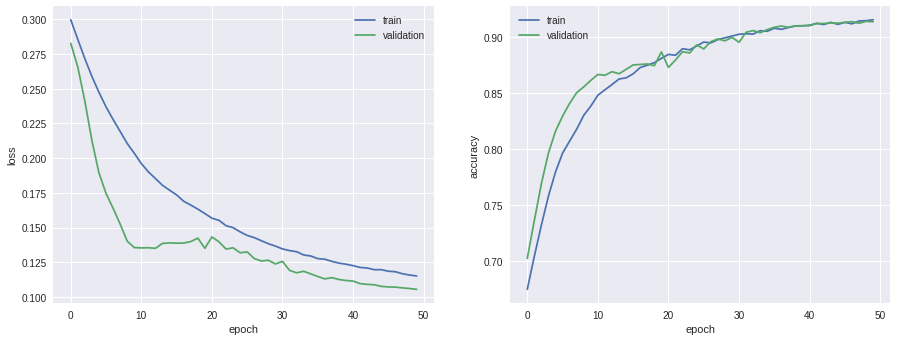

In [0]:
fig = plt.figure(figsize=(15, 12))

plt.subplot(221)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.subplot(222)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

## Load test images and predict

In [0]:
def plot_test_pred(test_image, test_pred, testIdx=0):
    fig = plt.figure(figsize=(12, 12))

    plt.subplot(221)
    plt.imshow(test_image[0, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.title('Test ' + str(testIdx), fontsize=16)

    plt.subplot(222)
    plt.imshow(test_pred[0, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.title('Predict ' + str(testIdx), fontsize=16)

    plt.show()

In [0]:
# load test images
input_shape = (512, 512, 1)
test_image = np.empty(30 * 512 * 512)
test_image = test_image.reshape((30, ) + input_shape)
for i in range(30):
    img_path = os.path.join(test_path, str(i) + '.png')
    img = Image.open(img_path)
    img = np.asarray(img, dtype=np.float32)
    img /= 255
    test_image[i, :, :, 0] = img

In [0]:
test_pred = model.predict(test_image)
test_pred = (test_pred > 0.5).astype(np.int)

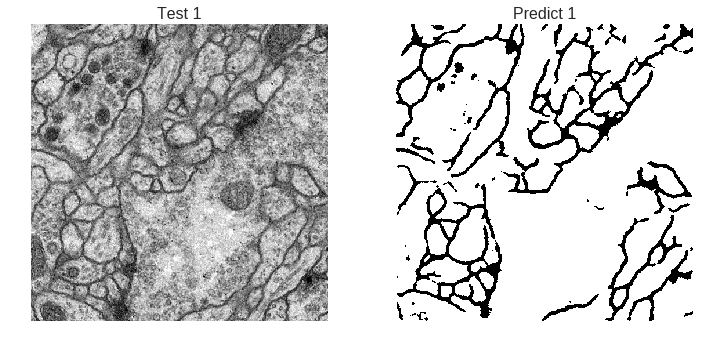

In [0]:
plot_test_pred(test_image=test_image, test_pred=test_pred, testIdx=1)